In [96]:
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

using Revise

include("tensor_builder.jl")
include("calculo_observables.jl")
include("monte_carlo_swap.jl")
include("parallel_monte_carlo_Glauber.jl")

include("efficient_observables.jl")

system_description_over_time (generic function with 1 method)

In [97]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, titled="Marginal expectation per spin over steps", savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title=titled,
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

## Pruebas

In [98]:
N = 50
t = 100
max_bound = 5

# TensotTrain de transición simpmle
A = build_transition_tensorchain(transition_rate, random_params(N))
# TensorTrain de probabilidad tiempo t simple
B_t = tensor_b_t(A, random_P0(N), t, max_bound)

# TensorTrain de transición paralela
A_plus = parallel_transition_tensor_train(transition_rate, parallel_random_params(N))

# TensorTrain de probabilidad tiempo t paralela con cadenas independientes
B_t_plus = tensor_b_t(A_plus, random_P0(N, 4), t, max_bound)

# TensorTrain de probabilidad tiempo t paralela con condiciones iniciales fijas
B_t_plus_fixed = tensor_b_t(A_plus, parallel_random_P0_fixed(N), t, max_bound)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:02
Progress: 100%|█████████████████████████████████████████| Time: 0:02:51


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.26842054266555077 0.24868695472578078 -0.25602684288339883 0.23720441825504143;;; 0.2560268372595563 0.2372044243251421 0.26842054352163613 -0.2486869538017637;;; 0.24868696562677114 -0.2684205362774428 -0.23720440682635804 -0.25602684958074085;;; 0.2372044128964586 -0.25602684395689845 0.24868696470275423 0.2684205371335285], [0.33152105397737236 0.22681398921448737 … 0.16442101567361078 -0.050770699197853805; 0.03723405800238162 0.04811605562930651 … 0.03489722076769249 0.31065496320157865; -0.03342076200009803 -0.02286521239775481 … -0.030076165347261194 0.005124912499595232; 0.0037535791409727647 0.004850780674278363 … 0.006387730001354206 0.03110983255323732;;; 0.23973040282859112 0.1640144654341533 … -0.221732129570028 -0.03666591518074281; 0.0269247933958646 0.034794054976016314 … -0.04706978906279689 0.22432301823308953; 0.0452264073357939 0.030942206773971855 … -0.05213559920315062 -0.006915824766205286; -0.00507950209

In [99]:
println("Suma total de B_t: ", sum_one_check(B_t))
println("Suma total de B_t_plus: ", sum_one_check(B_t_plus))
println("Suma total de B_t_plus_fixed: ", sum_one_check(B_t_plus_fixed),"\n")
println("Distribución marginal en el sitio 10 de B_t: ", marginal_distribution(B_t, 10))
println("Distribución marginal en el sitio 10 de B_t_plus: ", marginal_distribution(B_t_plus, 10))
println("Distribución marginal en el sitio 10 de B_t_plus_fixed: ", marginal_distribution(B_t_plus_fixed, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t: ", marginal_expected_value_simple(B_t, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus: ", marginal_expected_value_parallel(B_t_plus, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus_fixed: ", marginal_expected_value_parallel(B_t_plus_fixed, 10))

Suma total de B_t: 0.9999999999999974
Suma total de B_t_plus: 0.9999999999999922
Suma total de B_t_plus_fixed: 1.0000000000000058

Distribución marginal en el sitio 10 de B_t: [0.29555116223148803, 0.7044488377685095]
Distribución marginal en el sitio 10 de B_t_plus: [0.17334057987102516, 0.23678652989330215, 0.24931026012449328, 0.3405626301111722]
Distribución marginal en el sitio 10 de B_t_plus_fixed: [0.17334057987102752, 0.23678652989330562, 0.2493102601244967, 0.3405626301111771]

Valor esperado marginal en el sitio 10 de B_t: 0.4088976755370215
Valor esperado marginal en el sitio 10 de B_t_plus: (0.1546983200089559, 0.17974578047133816)
Valor esperado marginal en el sitio 10 de B_t_plus_fixed: (0.15469832000895845, 0.17974578047134065)


## Parallel Dynamic

In [100]:
N = 10                                 # Número de espines
T = 100                               # Número de iteraciones (tiempo)
params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0
P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallel( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0)
result_mc = run_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time = compute_marginal_magnetization_parallel(result_mc)   # magnetización de cada espín por instante de tiempo

# TensorTrains
max_bound = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

print("done")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


done

In [101]:
# params = (
#     N = 10,
#     beta_1 = 0.5,
#     beta_2 = 1.0,
#     j_vector = randn(N-1),
#     h_vector = randn(N),
#     p0 = 0.1
# )

In [102]:
print(params)

(N = 10, beta_1 = 0.06371801822830814, beta_2 = 0.7097587881946664, j_vector = [0.5641323464142185, -0.010628893321922961, 0.00039334031350457543, -0.23596306075478757, -0.7988108914747032, -0.6730132247305396, 0.4093377840558541, -0.6793261738095819, 0.2273886608641127], h_vector = [0.8717249764995463, -0.6129945633304204, -0.8912083613385657, 0.4565530279797301, 0.3671616830468598, -0.6051768730624789, -0.6216106997149315, -0.2615711126769453, 0.18247455570148086, -0.13246836500131676], p0 = 0.6116302427686796)

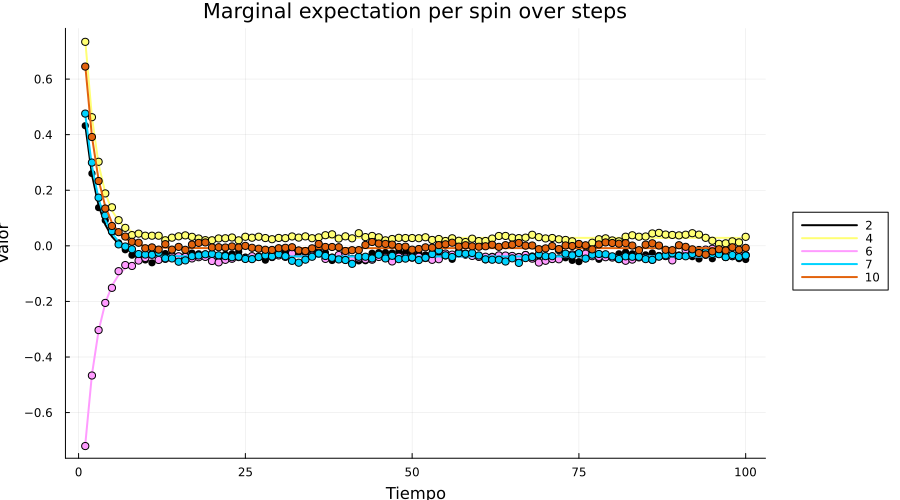

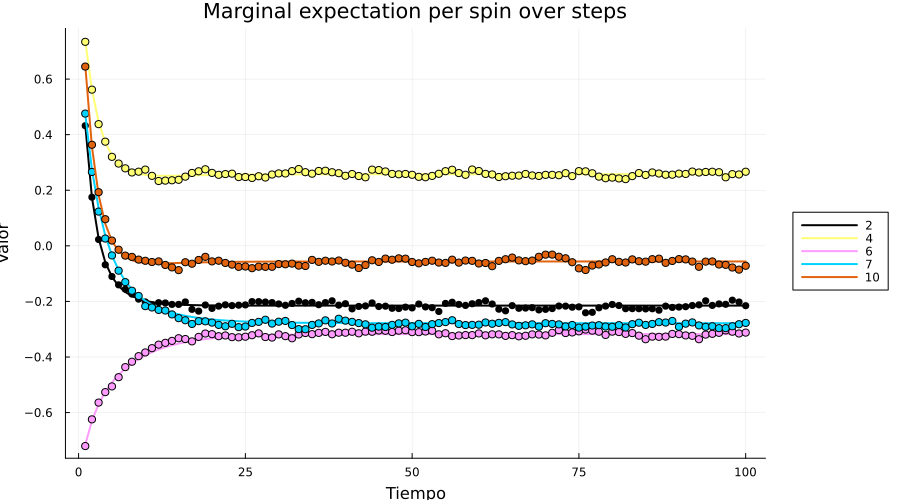

In [103]:
numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:2
    Sdots = mag_mc_time[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [104]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_plus_fixed[t]))
end

print(correlation_between_chains(B_t_plus_fixed[1]), "\n", covariance_between_chains(B_t_plus_fixed[1]), "\n")

[0.9999999999999999, 1.0, 1.0000000000000002, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0]
[0.8638905304116657, 0.8108041036764978, 0.5930943395821263, 0.45426896904396696, 0.9781205053507455, 0.4881336427570515, 0.7762597790598283, 0.9849568671255666, 0.9939908990580558, 0.5784920191534493]


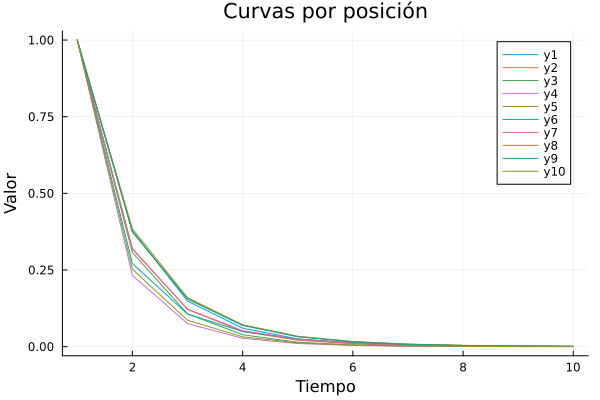

In [105]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")

### Some index references

    ( X  Y)

1-  (-1 -1)

2-  ( 1 -1)

3-  (-1  1)

4-  ( 1  1)

mag_tt_time[time][spin][X-Y]

mag_mc_time[X-Y][spin,time]

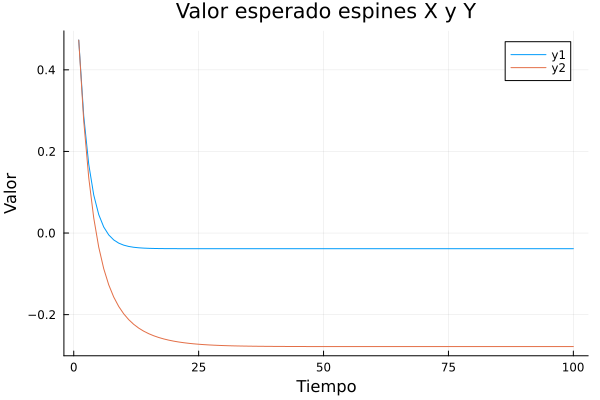

In [106]:
spin_X_ev_time = []
spin_Y_ev_time = []
spin_number = 7
for t in 1:100
    evs_X = mag_tt_time[t][spin_number][1]  # Valor esperado del espín X en el tiempo t
    evs_Y = mag_tt_time[t][spin_number][2]  # Valor esperado del espín Y en el tiempo t
    push!(spin_X_ev_time, evs_X)
    push!(spin_Y_ev_time, evs_Y)
end
mat_ev = hcat(spin_X_ev_time, spin_Y_ev_time)'  # Convierte a matriz 2 x T
plot(mat_ev', legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Valor esperado espines X y Y")  

In [107]:
4%3

1

In [108]:
9 ÷ 5

1

## Swap

In [109]:
N = 10                                 # Número de espines
# params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0

P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y


10-element Vector{Vector{Float64}}:
 [0.16863866689120763, 0.0, 0.0, 0.8313613331087923]
 [0.439389332949089, 0.0, 0.0, 0.560610667050911]
 [0.2600983004077916, 0.0, 0.0, 0.7399016995922084]
 [0.8276702271776862, 0.0, 0.0, 0.17232977282231374]
 [0.25586968195816856, 0.0, 0.0, 0.7441303180418314]
 [0.7930502340143091, 0.0, 0.0, 0.20694976598569093]
 [0.24416861151416772, 0.0, 0.0, 0.7558313884858323]
 [0.5517595246464252, 0.0, 0.0, 0.4482404753535748]
 [0.5683337597420058, 0.0, 0.0, 0.43166624025799416]
 [0.9087020864034157, 0.0, 0.0, 0.0912979135965843]

In [110]:
T = 10                             # Número de iteraciones (tiempo)

# params = (
#     N = 10,
#     beta_1 = 0.01,
#     beta_2 = 100.0,
#     j_vector = fill(1, N-1),
#     h_vector = fill(0,N),
#     p0 = 0.1
# )
  # Número de iteraciones (tiempo)
params = parallel_random_params(N)  

s = 0.3

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallelSwap( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0, s)
result_mc_swap = run_swap_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 100000, seed = 42)
observables_mc = compute_all_observables(result_mc_swap)


# TensorTrains
bond = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_swap = tensor_b_t_swap(A_plus, P0, T, bond, s, true)
B_t_parallel_fixed = tensor_b_t_over_time(A_plus, P0, T, bond)

system_of_observables_swap = system_description_over_time(B_t_swap, params)
system_of_observables_parallel = system_description_over_time(B_t_parallel_fixed, params)



print("done")



Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


done

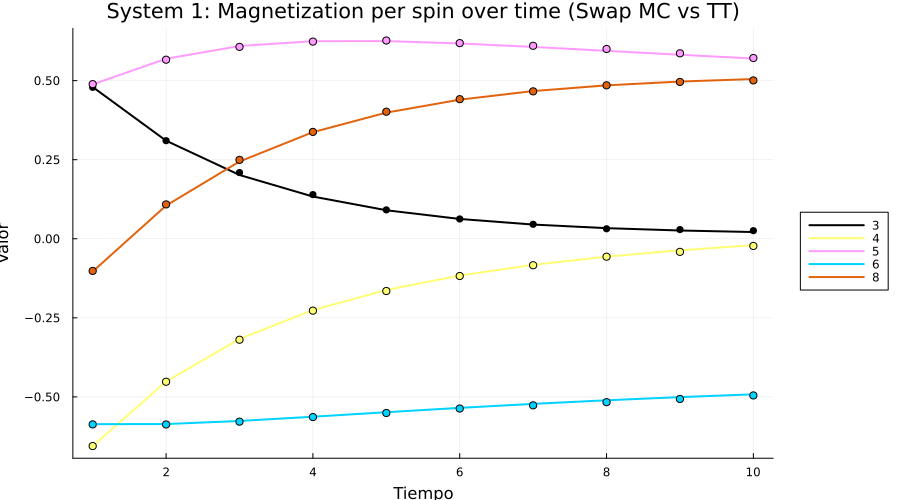

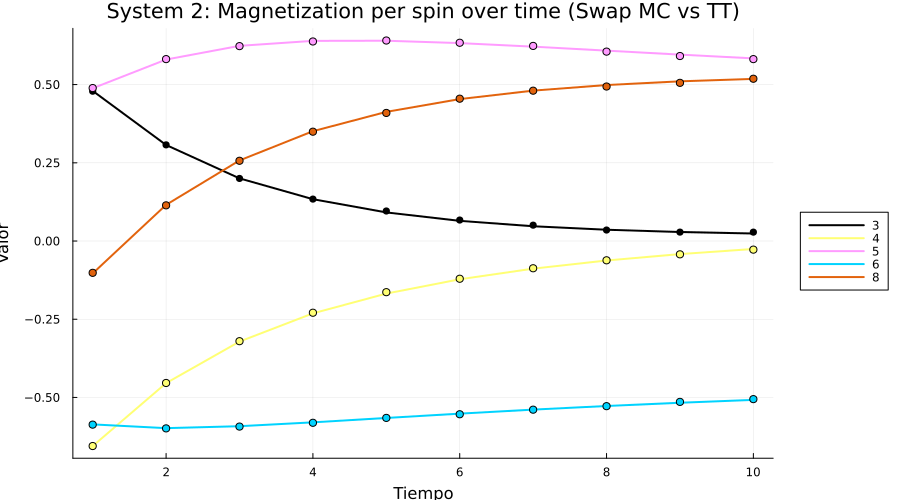

In [111]:
# Gráfica de resultados MonteCarlo vs TT magnteización por espin de cada cadena

mag_tt_time_swap = system_of_observables_swap.full_expected_values_t
mag_mc_time_swap = [observables_mc["magnetization_x"], observables_mc["magnetization_y"]]  # magnetización de cada espín por instante de tiempo

numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

T=10
for system in 1:2
    Sdots = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista, titled = "System $system: Magnetization per spin over time (Swap MC vs TT)",
                           savepath="sextuples_compare.png")
    display(p)
end

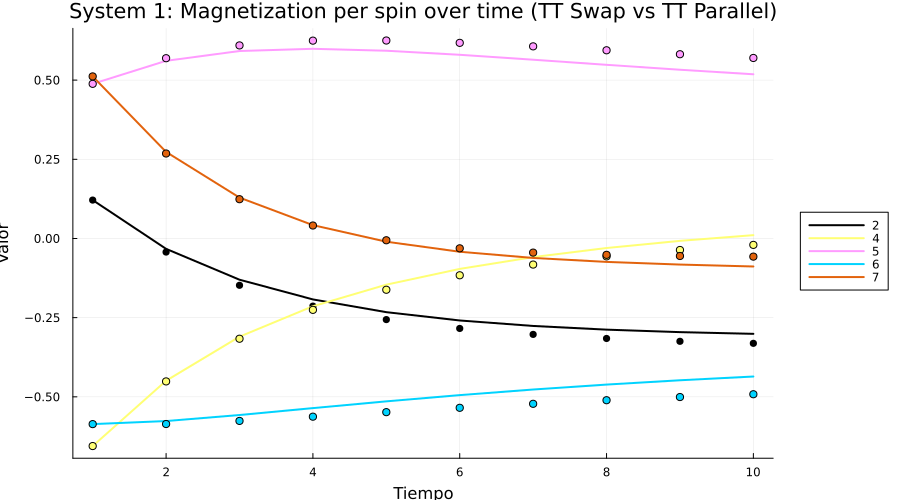

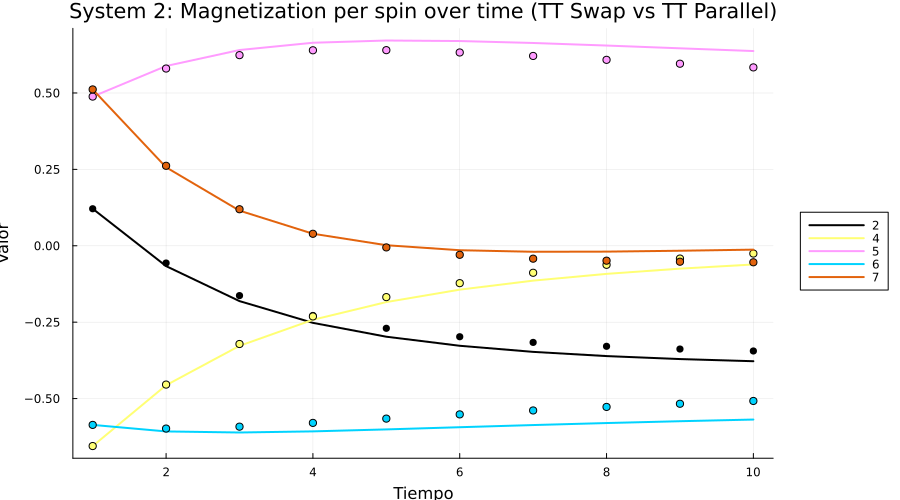

In [112]:
# Gráfica de resultados TT Swap vs TT Parallel magnteización por espin de cada cadena

mag_tt_time_swap = system_of_observables_swap.full_expected_values_t
mag_tt_time_parallel = system_of_observables_parallel.full_expected_values_t

numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)


for system in 1:2
    Sdots_ = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    Sdots = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Sdots[j, k] = mag_tt_time_parallel[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Slines, Sdots;
                           site_labels = str_lista, titled = "System $system: Magnetization per spin over time (TT Swap vs TT Parallel)",
                           savepath="sextuples_compare.png")
    display(p)
end

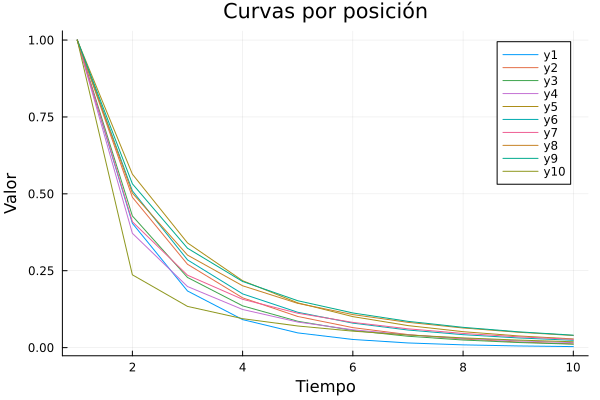

In [118]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_swap[t]))
end


# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")


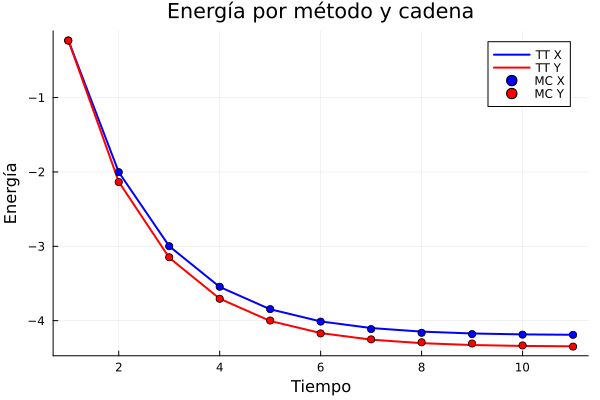

In [114]:
# Gráfica de resultados MonteCarlo vs TT energía por cadena

system_of_observables_swap = system_description_over_time(B_t_swap, params)

energy_mc_x = observables_mc["energy_x"]
energy_mc_y = observables_mc["energy_y"]
energy_tt = system_of_observables_swap.energy_t

T = length(energy_mc_x)
times = 1:T

# Extraer las energías X e Y de TT
energy_tt_x = [e[1] for e in energy_tt]
energy_tt_y = [e[2] for e in energy_tt]

q = plot(title="Energía por método y cadena", xlabel="Tiempo", ylabel="Energía", legend=:topright, grid=true)

# Líneas TT
plot!(q, times, energy_tt_x, color=:blue, linewidth=2, label="TT X")
plot!(q, times, energy_tt_y, color=:red, linewidth=2, label="TT Y")

# Puntos MC
scatter!(q, times, energy_mc_x, color=:blue, marker=:circle, label="MC X")
scatter!(q, times, energy_mc_y, color=:red, marker=:circle, label="MC Y")

display(q)